# Hankel Transforms on power spectra / correlation functions

The purpose of this notebook is to develop a robust way to do the hankel transforms of power-correlation functions. The general method has been established for a while (using Ogata's method a la the `hankel` package, but with a few optimizations), but some loose ends still need tying up -- eg. how best to do the necessary inter/extrapolation under different circumstances, and what limits to use on $k$ and $r$.

We have the formulas

\begin{align}
    \xi(r) &= \frac{1}{2\pi^2} \int_0^\infty P(k) k^2 \frac{\sin(k r)}{kr} dk \\
    P(k) &= 4\pi \int_0^\infty \xi(r) r^2 \frac{\sin(k r)}{kr} dr.
\end{align}

Note that for physical power spectra / correlation functions, these always converge. For linear power spectra, both ends go to zero, thus ensuring convergence. And that means by definition that $\xi(r)$ converges.

## The Transform Function

I'm going to copy-paste the Hankel Transform function from `halomod`, as it appears in this particular version (see below), to enable working on it more easily. 

In [1]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import warnings

In [2]:
def pfunc_linear(logk, p, lnk, power_pos):
    spl = spline(lnk, p, k=3)
    result = np.zeros_like(logk)
    inner_mask = (lnk.min() <= logk) & (logk <= lnk.max())
    result[inner_mask] = spl(logk[inner_mask])

    lower_mask = logk < lnk.min()
    if power_pos[0]:
        result[lower_mask] = np.exp((np.log(p[1]) - np.log(p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(p[0]))
    else:
        result[lower_mask] = (p[1] - p[0]) * (logk[lower_mask] - lnk[0]) / (lnk[1] - lnk[0]) + p[0]

    upper_mask = logk > lnk.max()
    if power_pos[1]:
        if p[-1] <=0 or p[-2] <= 0:
            raise ValueError("Something went horrible wrong")
        result[upper_mask] = np.exp(
            (np.log(p[-1]) - np.log(p[-2])) * (logk[upper_mask] - lnk[-1]) / (
                lnk[-1] - lnk[-2]) + np.log(p[-1])
        )
    else:
        result[upper_mask] = (p[-1] - p[-2]) * (logk[upper_mask] - lnk[-1]) / (
            lnk[-1] - lnk[-2]) + p[-1]

    return result

def get_sumspace(h, x_max=None):
    # Optimal value of nmax, given h.
    nmax = int(3.2 / h)
    
    x_nmax = np.pi * nmax * np.tanh(np.pi*np.sinh(h*nmax))
        
    if not x_max or x_nmax <= x_max:
        roots = np.arange(1, nmax + 1)
        t = h * roots
        s = np.pi * np.sinh(t)
        x = np.pi * roots * np.tanh(s / 2)
    else:
        t = []
        s = []
        x = []
        chunksize = 100
        i = 1
        while (not x) or (np.max(x) < x_max):
            roots = np.arange(i, i + chunksize)
            t.append(h * roots)
            s.append(np.pi * np.sinh(t[-1]))
            x.append(np.pi * roots * np.tanh(s[-1] / 2))
            i += chunksize
        t = np.array(t).flatten()
        s = np.array(s).flatten()
        x = np.array(x).flatten()
        
    dpsi = 1 + np.cosh(s)
    dpsi[dpsi != 0] = (np.pi * t * np.cosh(t) + np.sinh(s)) / dpsi[dpsi != 0]
    
    return x, np.pi * np.sin(x) * dpsi * x


def power_to_corr_ogata(
    power: np.ndarray, k: np.ndarray, r: np.ndarray, h=0.005,
    power_pos=(True, True), rtol=1e-3, atol=1e-15, _reverse=False,
    integration_max=None
):
    """
    Convert a 3D power spectrum to a correlation function.

    Uses Ogata's method (Ogata 2005) for Hankel Transforms in 3D.

    Parameters
    ----------
    power : np.ndarray
        The power spectrum to convert -- either 1D or 2D. If 1D, it is the power as a
        function of k. If 2D, the first dimension should be ``len(r)``, and the power
        to integrate is considered to be different for each ``r``.
    k : np.ndarray
        Array of same length as the last axis of ``power``, giving the fourier-space
        co-ordinates.
    r : np.ndarray
        The real-space co-ordinates to which to transform.
    h : int, optional
        Controls the spacing of the intervals (note the intervals are not equispaced).
        Smaller numbers give smaller intervals.
    power_pos : tuple of bool, optional
        Whether 'power' is definitely positive, at either end. If so, a slightly better
        extrapolation can be achieved.
    Notes
    -----
    See the `hankel <https://hankel.readthedocs.io>`_ documentation for details on the
    implementation here. This particular function is restricted to a spherical transform.
    """
    v = 'kr'
    if _reverse:
        v = v[::-1]

    func = 'corr' if _reverse else "power"

    lnk = np.log(k)
    
    if integration_max:
        x_max = integration_max * r.max()
    else:
        x_max = None
        
    x, sumparts = get_sumspace(h, x_max)

    if power_pos[0] and not np.all(power.T[:2] > 0):
        power_pos = (False, power_pos[1])

    if power_pos[1] and not np.all(power.T[-2:] > 0):
        power_pos = (power_pos[0], False)


    out = np.zeros(len(r))

    warn_upper = True
    warn_lower = True
    warn_conv = True
    for ir, rr in enumerate(r):
        kk = x / rr

        summand = sumparts * pfunc(np.log(kk), power[ir] if power.ndim == 2 else power, lnk, power_pos)
        cumsum = np.cumsum(summand)

        if kk.min() < k.min() and warn_lower:
            warnings.warn(
                f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                f"{v[0]}={kk.min():.2e}. Minimum provided was {k.min():.2e}. "
                f"Lowest value required is {x.min() / r.max():.2e}",
                stacklevel=2
            )
            warn_lower = False

        # If all k values accessed weren't interpolated, just return it.
        if kk.max() <= k.max():
            out[ir] = cumsum[-1]
        else:
            # Check whether we have convergence at k.max
            indx = np.where(kk > k.max())[0][0]

            if np.isclose(cumsum[indx], cumsum[indx - 1], atol=atol, rtol=rtol):
                # If it converged in the non-extrapolated part, return that.
                out[ir] = cumsum[indx]
            else:
                # Otherwise, warn the user, and just return the full sum.
                if warn_upper:
                    warnings.warn(
                        f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                        f"{v[0]}={kk.max():.2e}. Maximum provided was {k.max():.2e}. ",
                        stacklevel=2
                    )
                    warn_upper = False

                if not np.isclose(cumsum[-1], cumsum[-2], atol=atol, rtol=rtol) and warn_conv:
                    warnings.warn(
                        f"Hankel transform of {func} did not converge for {v[1]}={rr:.2e}. "
                        f"It is likely that higher {v[1]} will also not converge. "
                        f"Absolute error estimate = {cumsum[-1] - cumsum[-2]:.2e}. "
                        f"Relative error estimate = {cumsum[-1]/cumsum[-2] - 1:.2e}",
                        stacklevel=2
                    )
                    warn_conv = False

                out[ir] = cumsum[-1]

    return out / (2 * np.pi ** 2 * r ** 3)


def corr_to_power_ogata(corr, r, k, h=0.005, power_pos=(True, False), atol=1e-15, rtol=1e-3, integration_max=None):
    """
    Convert an isotropic 3D correlation function to a power spectrum.

    Uses Ogata's method (Ogata 2005) for Hankel Transforms in 3D.

    Parameters
    ----------
    corr : np.ndarray
        The correlation function to convert as a function of ``r``.
    r : np.ndarray
        Array of same length as ``corr``, giving the real-space co-ordinates.
    k : np.ndarray
        The fourier-space co-ordinates to which to transform.
    n : int, optional
        The number of subdivisions in the integral.
    h : int, optional
        Controls the spacing of the intervals (note the intervals are not equispaced).
        Smaller numbers give smaller intervals.

    Notes
    -----
    See the `hankel <https://hankel.readthedocs.io>`_ documentation for details on the
    implementation here. This particular function is restricted to a spherical transform.
    """
    return 8 * np.pi ** 3 * power_to_corr_ogata(corr, r, k, h, power_pos=power_pos, atol=atol, rtol=rtol, _reverse=True, integration_max=integration_max)

## The Main Idea

The function as implemented here does the standard Ogata transform, but it is passed a simple vector of power/correlation, rather than a callable function. This means it has to interpolate that vector to create a callable function, and will often have to extrapolate, if the extent of the transformed variable is too large. 

In this case, the function will try to extrapolate linearly in log-space, unless the function it's trying to extrapolate is negative (or zero) on that particular end, in which case it will do simple linear extrapolation. 
The slope of this extrapolation is gotten simply from the two last points on the curve, which is probably prone to error, and should be investigated. 

The idea then would be to enforce that both the underlying $k$ and $r$ vectors extend well into the regime in which they essentially become power-laws, so that this extrapolation is a reasonable thing to do. This should have the benefit that the transform is well-defined over any extent (i.e. the round-trip from $k$ to $r$ to $k$ again would work perfectly fine, even if the latter $k$ were extended). 

The main things to investigate, then, are:

* Relevant limits on the $k$ vector that need to be observed to get accurate results (the user is able to choose $k$ in `hmf`, so we can't bank on it entirely, but it should already be broad enough that `sigma` is accurate, so we can probably count on it being reasonable). 
* Relevant limits on the $r$ vector -- $r_{\rm min}$, $r_{\rm max}$ and $dr$. 
* How to do the extrapolation most robustly. 
* What the relevant value of $h$ is for power spectra and correlation functions

## Matter Correlation

In [3]:
from halomod import DMHaloModel

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
hm = DMHaloModel()
power = hm.power

In [31]:
r = np.logspace(-3, 3, 100)

In [32]:
pfunc = pfunc_linear
corr = power_to_corr_ogata(power, hm.k, r, h=0.005)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  """Entry point for launching an IPython kernel.


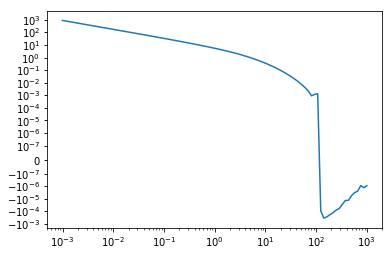

In [33]:
plt.plot(r, corr)
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-7)

Okay, so we should check the lower and upper bounds of $k$ and how they're performing under the extrapolation:

In [34]:
hm.lnk_min

-18.420680743952367

In [35]:
corr_default = corr

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.99e+04. 
  """
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  """


(-0.5, 0.5)

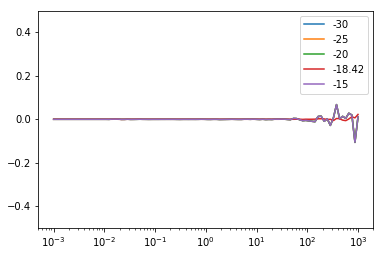

In [36]:
lnk_min_corrs = []
for lnk_min in [-30, -25, -20, -18.42, -15]:
    hm.lnk_min = lnk_min
    
    corr = power_to_corr_ogata(hm.power, hm.k, r, h=0.005)
    
    plt.plot(r, corr / corr_default - 1, label=str(lnk_min))
    
    lnk_min_corrs.append(corr)
    
plt.xscale('log')
plt.legend()
#plt.yscale('symlog', linthreshy=1e-7)
plt.ylim(-0.5, 0.5)

Good, so the default value is good to a percent or two over the whole range. Let's try lnk_max:

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.45e+02. 
  import sys
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.07e+03. 
  import sys
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  import sys
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.60e+05. 
  import sys


(-0.5, 0.5)

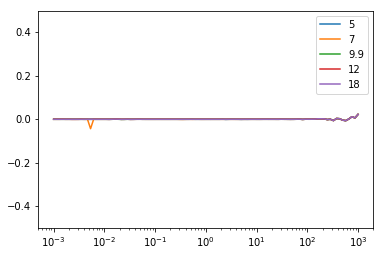

In [38]:
hm.lnk_min = -18.42

lnk_max_corrs = []
for lnk_max in [5, 7, 9.9, 12, 18]:
    hm.lnk_max = lnk_max
    
    corr = power_to_corr_ogata(hm.power, hm.k, r, h=0.005)
    
    plt.plot(r, corr / corr_default - 1, label=str(lnk_max))
    
    lnk_max_corrs.append(corr)
    
plt.xscale('log')
plt.legend()
#plt.yscale('symlog', linthreshy=1e-7)
plt.ylim(-0.5, 0.5)

Again, we're good to a couple of percent for the default value.

Let's try dlnk.

In [39]:
hm.dlnk

0.05

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.97e+04. 
  import sys
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  import sys


(-0.5, 0.5)

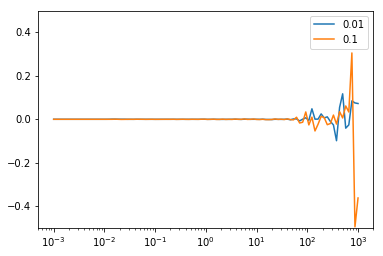

In [41]:
hm.lnk_max = 9.9

dlnk_corrs = []
for dlnk in [0.01, 0.1]:
    hm.dlnk = dlnk
    
    corr = power_to_corr_ogata(hm.power, hm.k, r, h=0.005)
    
    plt.plot(r, corr / corr_default - 1, label=str(dlnk))
    
    dlnk_corrs.append(corr)
    
plt.xscale('log')
plt.legend()
#plt.yscale('symlog', linthreshy=1e-7)
plt.ylim(-0.5, 0.5)

Going to dlnk=0.1 certainly seems to affect things here quite significantly (though only on scales we don't care about _directly_... we'll have to see how they affect the inverted power spectrum). Even at 0.05 (the default), it is affected at the 10% level, but again, only on fairly large scales. 

Note that this could a resolution thing, or it could be a numerical instability in the extrapolation due to closer points.

Finally let's look at h.

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+07. Maximum provided was 1.95e+04. 
  """
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=1.01e+07. Maximum provided was 1.95e+04. 
  """
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  """
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=1.01e+06. Maximum provided was 1.95e+04. 
  """


(-0.5, 0.5)

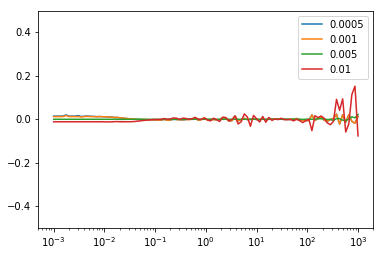

In [43]:
hm.dlnk = 0.05

h_corrs = []
for h in [0.0005, 0.001, 0.005, 0.01]:
    corr = power_to_corr_ogata(hm.power, hm.k, r, h=h)
    
    plt.plot(r, corr / corr_default - 1, label=str(h))
    
    dlnk_corrs.append(corr)
    
plt.xscale('log')
plt.legend()
#plt.yscale('symlog', linthreshy=1e-7)
plt.ylim(-0.5, 0.5)

Here we do see some systematic differences, but only at very small magnitude. It seems like 0.005 is good enough.

## Correlation to power.

Now that we're fairly confident we got the correlation OK, we need to get the power spectrum back. The weird things here are that the correlation function goes negative and has a negative power-law-ish thing going on. It's at a fairly low level, but not getting it right will lead to bad errors in the power spectrum at small $k$. Also, the correlation function is much more peaked at small $r$ and thus may need a smaller $h$.

In [44]:
r_hires = np.logspace(-3, 3, 1000)
corr_hires = power_to_corr_ogata(hm.power, hm.k, r_hires, h=0.005)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  


Our test will be to get back the power spectrum at the full range we input it. This is only possible if our extrapolation is reasonable. Unfortunately, it looks like there's a bit of a spike in the correlation that might make our extrapolation a bit crazy. We'll see.

In [45]:
power_roundtrip = corr_to_power_ogata(corr_hires, r_hires, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:166: UserWarning: In hankel transform, corr at k=1.00e-08 was extrapolated to r=2.01e+11. Maximum provided was 1.00e+03. 
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:166: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.26e-06


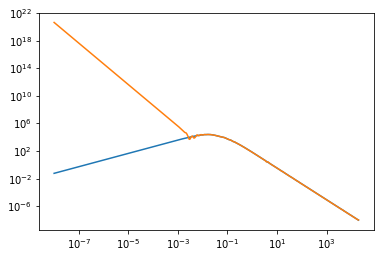

In [46]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip)
plt.xscale('log')
plt.yscale('log')

OK, it looks like the large-scale extrapolation did _not_ do well here. That's kinda understandable since we did a linear extrapolation instead of log. Let's try a log extrapolation. All we have to do is redefine the `pfunc`:

In [63]:
def pfunc_log(logk, p, lnk, power_pos):
    spl = spline(lnk, p, k=3)
    result = np.zeros_like(logk)
    inner_mask = (lnk.min() <= logk) & (logk <= lnk.max())
    result[inner_mask] = spl(logk[inner_mask])

    lower_mask = logk < lnk.min()
    if power_pos[0]:
        result[lower_mask] = np.exp((np.log(p[1]) - np.log(p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(p[0]))
    else:
        # Do a -log extrapolation
        result[lower_mask] = -np.exp(
            (np.log(-p[1]) - np.log(-p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(-p[0])
        )

    upper_mask = logk > lnk.max()
    if power_pos[1]:
        result[upper_mask] = np.exp(
            (np.log(p[-1]) - np.log(p[-2])) * (logk[upper_mask] - lnk[-1]) / (
                lnk[-1] - lnk[-2]) + np.log(p[-1])
        )
    else:
        # Do a -log extrapolation
        result[upper_mask] = -np.exp(
            (np.log(-p[-1]) - np.log(-p[-2])) * (logk[upper_mask] - lnk[-1]) / (
                lnk[-1] - lnk[-2]) + np.log(-p[-1])
        )

    return result

First let's look at this extrapolated function:

In [64]:
r_super_large = np.logspace(-5, 10, 1000)
corr_extended = pfunc_log(np.log(r_super_large), corr_hires, np.log(r_hires), (True, False))

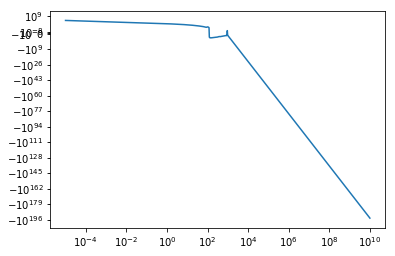

In [65]:
plt.plot(r_super_large, corr_extended)
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-8)

The problem here is that because of the blip at the end (or numerical noise?), the extrapolation super fails. One way around this may actually be to assume that stuff over $r=1000$ just doesn't contribute like ever, and call it zero. Let's try that:

In [66]:
def pfunc_zero(logk, p, lnk, power_pos):
    spl = spline(lnk, p, k=3)
    result = np.zeros_like(logk)
    inner_mask = (lnk.min() <= logk) & (logk <= lnk.max())
    result[inner_mask] = spl(logk[inner_mask])

    lower_mask = logk < lnk.min()
    if power_pos[0]:
        result[lower_mask] = np.exp((np.log(p[1]) - np.log(p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(p[0]))
    else:
        # Do a -log extrapolation
        result[lower_mask] = 0

    upper_mask = logk > lnk.max()
    if power_pos[1]:
        result[upper_mask] = np.exp(
            (np.log(p[-1]) - np.log(p[-2])) * (logk[upper_mask] - lnk[-1]) / (
                lnk[-1] - lnk[-2]) + np.log(p[-1])
        )
    else:
        # Do a -log extrapolation
        result[upper_mask] = 0

    return result

In [67]:
pfunc = pfunc_zero
power_roundtrip0 = corr_to_power_ogata(corr_hires, r_hires, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.26e-06


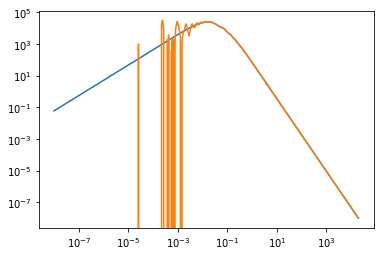

In [68]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip0)
plt.xscale('log')
plt.yscale('log')

OK, this also didn't do well. What if we try to increase the range of $r$?

In [69]:
pfunc = pfunc_log
r_hires_larger = np.logspace(-3, 4, 1000)
corr_hires_larger = power_to_corr_ogata(hm.power, hm.k, r_hires_larger)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  This is separate from the ipykernel package so we can avoid doing imports until


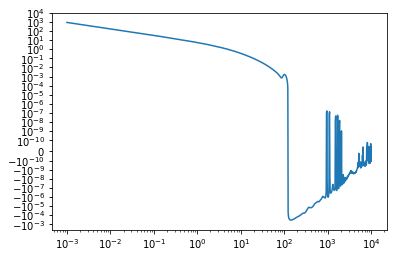

In [72]:
plt.plot(r_hires_larger, corr_hires_larger)
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-10)

In [70]:
power_roundtrip_larger = corr_to_power_ogata(corr_hires_larger, r_hires_larger, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=1.00e-08 was extrapolated to r=2.01e+11. Maximum provided was 1.00e+04. 
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: Hankel transform of corr did not converge for k=1.00e-08. It is likely that higher k will also not converge. Absolute error estimate = nan. Relative error estimate = nan
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.2

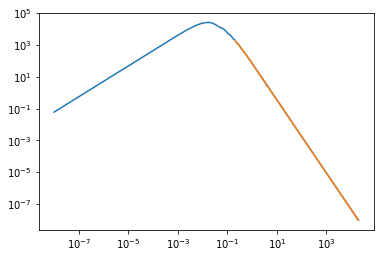

In [71]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_larger)
plt.xscale('log')
plt.yscale('log')

OK, so something went really wrong here too. But, it really does look like the tail of the correlation function should be just a negative power-law. If we can somehow model that, we could check. 

In [73]:
from scipy.interpolate import UnivariateSpline

In [74]:
UnivariateSpline?

In [81]:
def pfunc_logspline(logk, p, lnk, power_pos):
    spl = spline(lnk, p, k=3)
    result = np.zeros_like(logk)
    inner_mask = (lnk.min() <= logk) & (logk <= lnk.max())
    result[inner_mask] = spl(logk[inner_mask])

    lower_mask = logk < lnk.min()
    if power_pos[0]:
        result[lower_mask] = np.exp((np.log(p[1]) - np.log(p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(p[0]))
    else:
        # Do a -log extrapolation
        result[lower_mask] = -np.exp(
            (np.log(-p[1]) - np.log(-p[0])) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]) + np.log(-p[0])
        )

    upper_mask = logk > lnk.max()
    if power_pos[1]:
        result[upper_mask] = np.exp(
            (np.log(p[-1]) - np.log(p[-2])) * (logk[upper_mask] - lnk[-1]) / (
                lnk[-1] - lnk[-2]) + np.log(p[-1])
        )
    else:
        indx = np.argmin(p)
        this_lnk = lnk[indx:]
        this_p = p[indx:]
        
        this_lnk = this_lnk[this_p < 0]
        this_p = this_p[this_p <0]
        logSpline = UnivariateSpline(this_lnk, np.log(-this_p), k=1)
        
        # Do a -log extrapolation
        result[upper_mask] = -np.exp(logSpline(logk[upper_mask]))

    return result

In [82]:
pfunc = pfunc_logspline
power_roundtrip_larger = corr_to_power_ogata(corr_hires_larger, r_hires_larger, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=3.65e-06 was extrapolated to r=5.50e+08. Maximum provided was 1.00e+04. 
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.26e-06


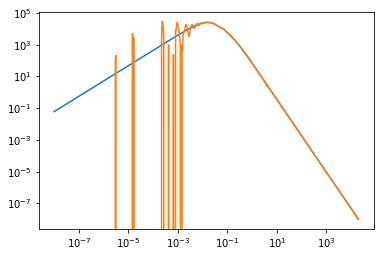

In [83]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_larger)
plt.xscale('log')
plt.yscale('log')

In [84]:
r_super_large = np.logspace(-5, 10, 1000)
corr_extended = pfunc_logspline(np.log(r_super_large), corr_hires, np.log(r_hires), (True, False))

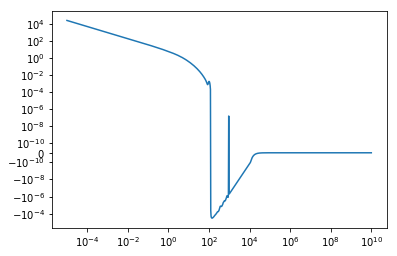

In [85]:
plt.plot(r_super_large, corr_extended)
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-10)

OK, this still didn't work somehow. Let's try something excessive.

In [86]:
r_enormous = np.logspace(-3, 10, 2000)
corr_enormous = power_to_corr_ogata(hm.power, hm.k, r_enormous)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In hankel transform, power at r=2.50e+06 was extrapolated to k=9.89e-09. Minimum provided was 1.00e-08. Lowest value required is 2.47e-12
  


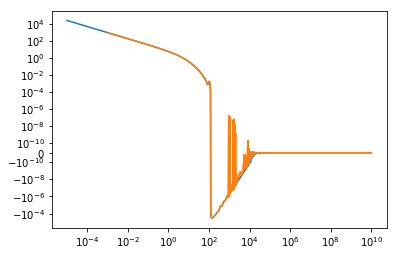

In [87]:
plt.plot(r_super_large, corr_extended)
plt.plot(r_enormous, corr_enormous)
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-10)

In [88]:
pfunc = pfunc_logspline
power_roundtrip_enormous = corr_to_power_ogata(corr_enormous, r_enormous, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.26e-06


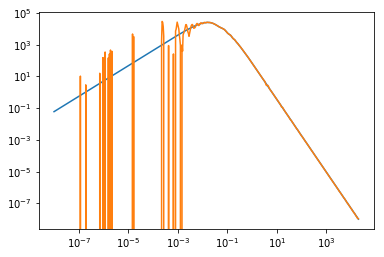

In [89]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_enormous)
plt.xscale('log')
plt.yscale('log')

OK, still didn't work. Higher res?

In [90]:
r_ginormous = np.logspace(-3, 10, 10000)
corr_ginormous = power_to_corr_ogata(hm.power, hm.k, r_ginormous)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=2.01e+06. Maximum provided was 1.95e+04. 
  
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In hankel transform, power at r=2.47e+06 was extrapolated to k=1.00e-08. Minimum provided was 1.00e-08. Lowest value required is 2.47e-12
  


In [91]:
pfunc = pfunc_logspline
power_roundtrip_ginormous = corr_to_power_ogata(corr_ginormous, r_ginormous, hm.k)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=2.53e+01 was extrapolated to r=9.76e-04. Minimum provided was 1.00e-03. Lowest value required is 1.26e-06


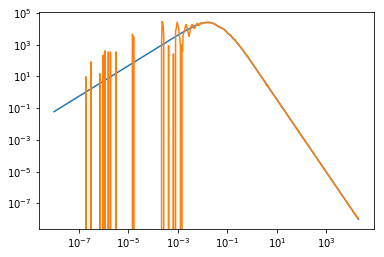

In [92]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_ginormous)
plt.xscale('log')
plt.yscale('log')

Nope. Looks like you just can't do it? Might just have to restrict the range of output $k$. Maybe we need to use the smaller $h$ to get these scales back...

In [93]:
corr_ginormous_large_h = power_to_corr_ogata(hm.power, hm.k, r_ginormous, h=1e-4)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In hankel transform, power at r=1.00e-03 was extrapolated to k=1.01e+08. Maximum provided was 1.95e+04. 
  """Entry point for launching an IPython kernel.
/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In hankel transform, power at r=4.95e+04 was extrapolated to k=9.98e-09. Minimum provided was 1.00e-08. Lowest value required is 4.93e-14
  """Entry point for launching an IPython kernel.


In [100]:
power_roundtrip_ginormous_large_h = corr_to_power_ogata(corr_ginormous_large_h, r_ginormous, hm.k, h=1e-6)
power_roundtrip_ginormous_mid_h = corr_to_power_ogata(corr_ginormous_large_h, r_ginormous, hm.k, h=1e-5)


/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: In hankel transform, corr at k=5.13e-02 was extrapolated to r=9.62e-04. Minimum provided was 1.00e-03. Lowest value required is 2.53e-09


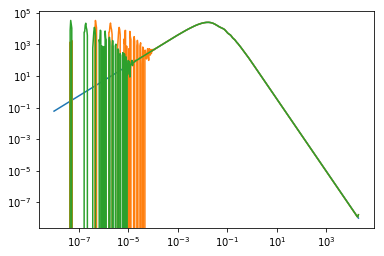

In [102]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_ginormous_mid_h)
plt.plot(hm.k, power_roundtrip_ginormous_large_h)
plt.xscale('log')
plt.yscale('log')

OK, so this seems to be an issue with too low of a $h$ in the corr-to-power transform. Why?

Perhaps we can plot out the summand to see what's going on, at say $k=10^{-3}$.

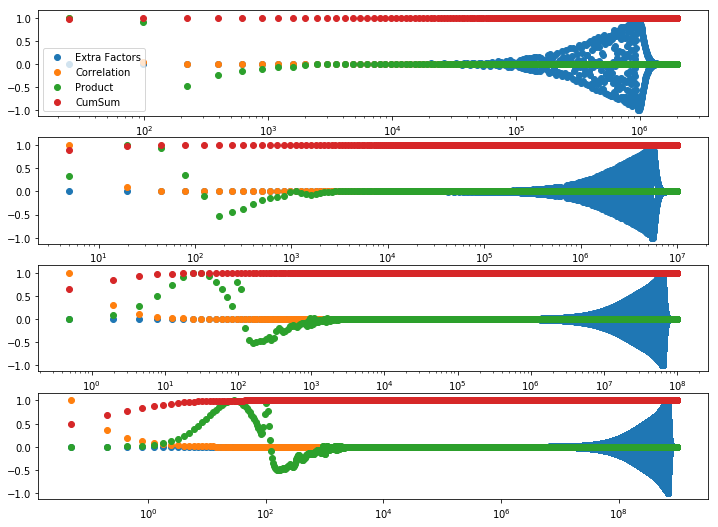

In [121]:
fig, ax = plt.subplots(4, 1, figsize=(12, 9))

use_roots = True

for i, h in enumerate([0.005, 0.001, 0.0001, 0.00001]):
    x, summand_parts = get_sumspace(h)
    R = x / 1e-3
    
    fnc = pfunc(np.log(R), corr_ginormous, np.log(r_ginormous), (True, False))

    if not use_roots:
        R = np.arange(len(R))
    
    cumsum = np.cumsum(fnc)
    
    ax[i].scatter(R, summand_parts/summand_parts.max(), label='Extra Factors')
    ax[i].scatter(R, fnc/fnc.max(), label="Correlation")
    ax[i].scatter(R, (summand_parts * fnc) /( summand_parts*fnc).max(), label="Product")
    ax[i].scatter(R, cumsum / cumsum.max(), label='CumSum')
    
    if use_roots:
        ax[i].set_xscale('log')
ax[0].legend()

OK, so what this is saying is that the cumulative sum is most influenced by the peak in the product around $r = x/k = 20-30$. When $h$ is largeish (0.005), the smallest $x \sim 10 h$ is already too large to properly capture this peak. Unfortunately, it does not seem to be a peak in either the extra factors themselves, or the correlation function, just their product. Let's try zoomin in on this region. 

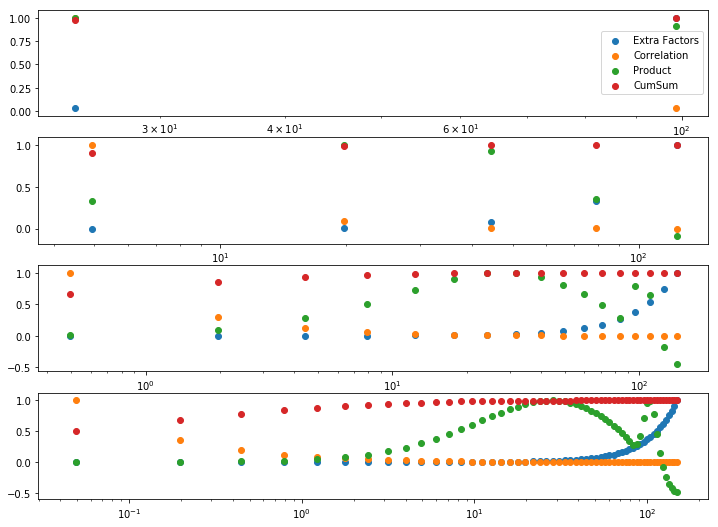

In [122]:
fig, ax = plt.subplots(4, 1, figsize=(12, 9))

use_roots = True

for i, h in enumerate([0.005, 0.001, 0.0001, 0.00001]):
    x, summand_parts = get_sumspace(h)
    R = x / 1e-3
    
    summand_parts = summand_parts [R < 150]
    R = R[R<150]
    
    fnc = pfunc(np.log(R), corr_ginormous, np.log(r_ginormous), (True, False))

    if not use_roots:
        R = np.arange(len(R))
    
    cumsum = np.cumsum(fnc)
    
    ax[i].scatter(R[R<150], summand_parts/summand_parts.max(), label='Extra Factors')
    ax[i].scatter(R, fnc/fnc.max(), label="Correlation")
    ax[i].scatter(R, (summand_parts * fnc) /( summand_parts*fnc).max(), label="Product")
    ax[i].scatter(R, cumsum / cumsum.max(), label='CumSum')
    
    if use_roots:
        ax[i].set_xscale('log')
ax[0].legend()

I think the point here is that we will never need scales beyond probably the BAO peak. We can test this theory out with an even smaller $k$:

0.0001 0.008259679082802401
1e-05 1.1202356257906547
1e-06 14.833325521049591
1e-07 110.16523659101848
1e-08 673.061875011396


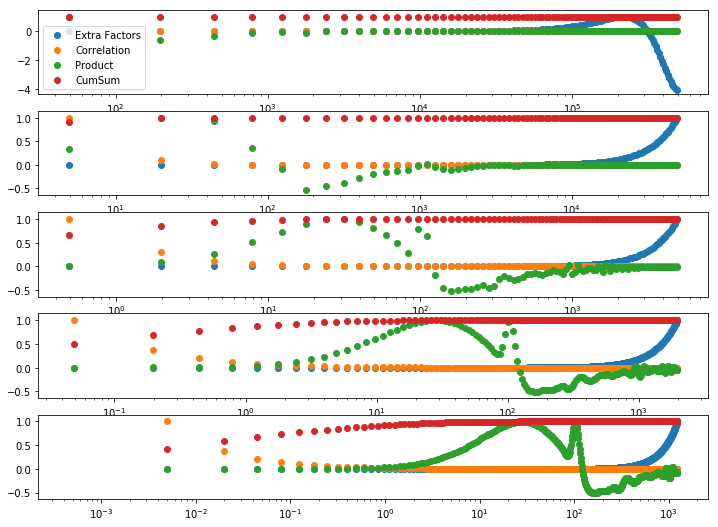

In [160]:
fig, ax = plt.subplots(5, 1, figsize=(12, 9))

use_roots = True
pfunc = pfunc_logspline

Rmax = 1000
k = 1e-5

for i, h in enumerate([1e-4, 1e-5, 1e-6, 1e-7, 1e-8]):
    x, summand_parts = get_sumspace(h, x_max=Rmax * k)
    R = x / k
    
    summand_parts = summand_parts
    R = R
    
    fnc = pfunc(np.log(R), corr_ginormous, np.log(r_ginormous), (True, False))

    if not use_roots:
        R = np.arange(len(R))
    
    cumsum = np.cumsum(fnc)
    
    print(h, cumsum[-1])
    
    ax[i].scatter(R, summand_parts/summand_parts.max(), label='Extra Factors')
    ax[i].scatter(R, fnc/fnc.max(), label="Correlation")
    ax[i].scatter(R, (summand_parts * fnc) /( summand_parts*fnc).max(), label="Product")
    ax[i].scatter(R, cumsum / cumsum.max(), label='CumSum')
    
    if use_roots:
        ax[i].set_xscale('log')
ax[0].legend()

In fact, the peak here seems to always be at about $r=30$, regardless of the $k$.

One weird thing is that the cumulative sum keeps getting bigger with decreasing h... I'm not sure I understand that. Let's try doing the actual computation with a very small $h$, and using the fact that we don't need the whole range of $x$.

This would take an awful long time under the current implementation -- we'll need to change it so that the range of $x$ is different for each $k$:

In [168]:
def power_to_corr_ogata_each(
    power: np.ndarray, k: np.ndarray, r: np.ndarray, h=0.005,
    power_pos=(True, True), rtol=1e-3, atol=1e-15, _reverse=False,
    integration_max=None
):
    v = 'kr'
    if _reverse:
        v = v[::-1]

    func = 'corr' if _reverse else "power"

    lnk = np.log(k)
    

    if power_pos[0] and not np.all(power.T[:2] > 0):
        power_pos = (False, power_pos[1])

    if power_pos[1] and not np.all(power.T[-2:] > 0):
        power_pos = (power_pos[0], False)


    out = np.zeros(len(r))

    warn_upper = True
    warn_lower = True
    warn_conv = True
    for ir, rr in enumerate(r):
        if integration_max:
            x_max = integration_max * rr
        else:
            x_max = None
            
        x, sumparts = get_sumspace(h, x_max)

        kk = x / rr

        summand = sumparts * pfunc(np.log(kk), power[ir] if power.ndim == 2 else power, lnk, power_pos)
        cumsum = np.cumsum(summand)

        if kk.min() < k.min() and warn_lower:
            warnings.warn(
                f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                f"{v[0]}={kk.min():.2e}. Minimum provided was {k.min():.2e}. "
                f"Lowest value required is {x.min() / r.max():.2e}",
                stacklevel=2
            )
            warn_lower = False

        # If all k values accessed weren't interpolated, just return it.
        if kk.max() <= k.max():
            out[ir] = cumsum[-1]
        else:
            # Check whether we have convergence at k.max
            indx = np.where(kk > k.max())[0][0]

            if np.isclose(cumsum[indx], cumsum[indx - 1], atol=atol, rtol=rtol):
                # If it converged in the non-extrapolated part, return that.
                out[ir] = cumsum[indx]
            else:
                # Otherwise, warn the user, and just return the full sum.
                if warn_upper:
                    warnings.warn(
                        f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                        f"{v[0]}={kk.max():.2e}. Maximum provided was {k.max():.2e}. ",
                        stacklevel=2
                    )
                    warn_upper = False

                if not np.isclose(cumsum[-1], cumsum[-2], atol=atol, rtol=rtol) and warn_conv:
                    warnings.warn(
                        f"Hankel transform of {func} did not converge for {v[1]}={rr:.2e}. "
                        f"It is likely that higher {v[1]} will also not converge. "
                        f"Absolute error estimate = {cumsum[-1] - cumsum[-2]:.2e}. "
                        f"Relative error estimate = {cumsum[-1]/cumsum[-2] - 1:.2e}",
                        stacklevel=2
                    )
                    warn_conv = False

                out[ir] = cumsum[-1]

    return out / (2 * np.pi ** 2 * r ** 3)

def corr_to_power_ogata_each(corr, r, k, h=0.005, power_pos=(True, False), atol=1e-15, rtol=1e-3, integration_max=None):
    return 8 * np.pi ** 3 * power_to_corr_ogata_each(corr, r, k, h, power_pos=power_pos, atol=atol, rtol=rtol, _reverse=True, integration_max=integration_max)

In [171]:
power_roundtrip_ginormous_h = corr_to_power_ogata_each(corr_ginormous_large_h, r_ginormous, hm.k, h=1e-5, integration_max=600)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: In hankel transform, corr at k=5.13e-02 was extrapolated to r=9.62e-04. Minimum provided was 1.00e-03. Lowest value required is 2.53e-09


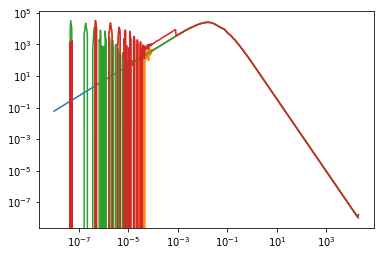

In [172]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip_ginormous_mid_h)
plt.plot(hm.k, power_roundtrip_ginormous_large_h)
plt.plot(hm.k, power_roundtrip_ginormous_h)

plt.xscale('log')
plt.yscale('log')

It doesn't look like I will easily solve this. Perhaps the best course of action is to restrict the halo model range of $k$ to something more modest, and use $h=0.005$. What's the lowest $k$ we can trust for $h=0.005$?

In [182]:
pfunc = pfunc_logspline
power_roundtrip0 = corr_to_power_ogata(corr_ginormous_large_h, r_ginormous, hm.k, h=0.001, integration_max=600)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:195: UserWarning: In hankel transform, corr at k=5.10e+00 was extrapolated to r=9.67e-04. Minimum provided was 1.00e-03. Lowest value required is 2.53e-07


(1000.0, 100000.0)

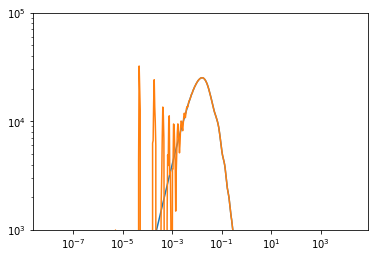

In [183]:
plt.plot(hm.k, hm.power)
plt.plot(hm.k, power_roundtrip0)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e3, 1e5)

In [191]:
%timeit power_roundtrip0 = corr_to_power_ogata(corr_ginormous_large_h, r_ginormous, hm.k, h=0.001, integration_max=600)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:195: UserWarning: In hankel transform, corr at k=5.10e+00 was extrapolated to r=9.67e-04. Minimum provided was 1.00e-03. Lowest value required is 2.53e-07


1.83 s ± 85.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [192]:
%timeit power_roundtrip0 = corr_to_power_ogata(corr_ginormous_large_h, r_ginormous, hm.k, h=0.001)

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:195: UserWarning: In hankel transform, corr at k=5.10e+00 was extrapolated to r=9.67e-04. Minimum provided was 1.00e-03. Lowest value required is 2.53e-07


1.89 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


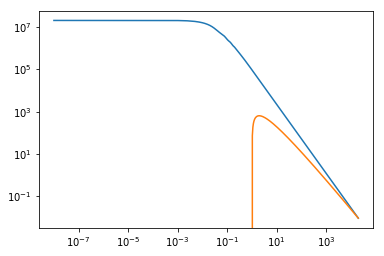

In [16]:
plt.plot(hm.k,  np.exp(hm._unnormalised_lnT))
plt.plot(hm.k, hm.k**-1.5 * np.log(hm.k) * np.exp(hm._unnormalised_lnT)[-1] / (hm.k**-1.5 * np.log(hm.k))[-1])
plt.xscale('log')
plt.yscale('log')